# Bayesian optimization tutorial code to use with Comsol

This document is for the bayesian optimization tutorial using the emukit library.
Based tutorial example can be found below

https://nbviewer.org/github/emukit/emukit/blob/main/notebooks/Emukit-tutorial-Bayesian-optimization-introduction.ipynb

First, we are running the code with the jupyter notebook for a simple analytical function.
At the end, I will summerize the part we need to modify for the comsol simulation using the matlab together.

First, we need to install the miniconda
(https://docs.conda.io/en/latest/miniconda.html)

Open a command window and create a virtual environment (ex. 'emukit_tutorial')

If you are not familier with the virtual environment, you can type the line below after opening the miniconda command window

> conda create -n emukit_tutorial python==3.7

then activate the virtual environment

> conda activate emukit_tutorial

and then install the emukit, jupyter, pandas, matplotlib, scipy

> pip install emukit jupyter pandas matplotlib scipy

Updated versions would might also work, but this tutorial is using python version 3.7, emukit version 0.4.9

Then, turn on the jupyter notebook, and open the ipynb file including the tutorial (this file)

> jupyter notebook

## Initialization

First, we setup the base parameters for the optimization

In [1]:
import os
import time
import numpy as np

start_time       = time.time() # Saving the current time to calculate the time cost later
sim_time         = 0           # Default time initialization
folder_path      = os.getcwd() # current folder path information

np.random.seed   (100)         # fixing the random seed to enable reproducibility
# N_Design_param   = 2         # Number of design parameters(2d)
# N_Init           = 10        # Number of initial guess points(2d)
N_Design_param   = 9           # Number of design parameters(9d)
N_Init           = 50         # Number of initial guess points(9d)
Max_Iter_Time    = 300        # Current optimization is not stopped at a specific convergence condition. (second)
                               # Considering we are solving a data scarcity problem, we setup the maximum sim time.

Then, we setup the design parameters.

Here, we will consider a nine design parameter optimization problem for the STYBLINSKI-TANG function.

https://www.sfu.ca/~ssurjano/stybtang.html

$f(X_i)=(\sum(x_i^4-16x_i^2+5x_i)) / 2$

The function is usually evaluated on the hypercube $x_i$ in [-5, 5] when $i$ indicates the dimension.

The global minimum is -39.166 * d when d is the dimension and all the $x_i$ values are -2.903534.

In this example, we will consider the design parameters to be a continousparameter between 0 to 1.

For the functional calculation, we transfer the values to [-5, 5] and calculate the function.

Below is a 9D example, and we can use 2d with with the comment out code.
(should also change the N_Design_param,N_init above together above)

Here, de define the parameter space of the problem

In [2]:
from emukit.core import ParameterSpace, ContinuousParameter

# parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
#                                   ContinuousParameter('x2', 0, 1)])

parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
                                  ContinuousParameter('x2', 0, 1),
                                  ContinuousParameter('x3', 0, 1),
                                  ContinuousParameter('x4', 0, 1),
                                  ContinuousParameter('x5', 0, 1),
                                  ContinuousParameter('x6', 0, 1),
                                  ContinuousParameter('x7', 0, 1),
                                  ContinuousParameter('x8', 0, 1),
                                  ContinuousParameter('x9', 0, 1)])


Here, we are defining the STYBLINSKI-TANG function above.

To normalize the output, we fit roughly considering the min-max transformation
(max:1125 at (5,5,...,5), min -352.5  at (-2.9, -2.9, ..., -2.9))

At the end of the tutorial, we will show this part will be modified for the comsol simulation, which is the only part we need to consider when changing the function we want to use.

In the jupyter notebook, we are not going to directly run the comsol as it requires the comsol license.

In [3]:
def Test_Function(x):
    print("Functional call happened")        # Print to check whether the function is called
    X=x*10 - 5                               # transfering the value [0,1] to [-5,5]
    return (np.sum((X**4-16*X**2+5*X)/2))      # Calculating (x^4-16x^2+5x)/2 for each x, and sum

Objective_Function = Test_Function           # Naming the objective function
# Objective_Function = Comsol_Sim            # replace later when using the comsol sim.



## Initial point define and calculation

Here, we define the random points for the initial guess
For the advanced users, one can change it with different kinds of initial point definition such as latin hypercube of sobol sequency et al.

In [4]:
import pandas as pd

x_random  = np.random.rand(max([N_Init])*N_Design_param)[:, None]
                                             # Making an array of random variables
x         = np.reshape(x_random[0:N_Init*N_Design_param,:], (N_Init,-1)) 
                                             # Reshaping to an array size (N_Init*N_Design_param)
X_init    = x[0]                             # First initial guess point to calculate the function
Y_init    = Objective_Function(X_init)       # Functional call for the initial guess

print('first three x is \n',x[0:3,:])
print('X_init is \n',X_init)
print('Y_init \n',Y_init)

bo_df         =pd.DataFrame(columns = ['iter','v1','v2','v3','v4','v5','v6','v7','v8','v9','obj'])
iteration_info=[1,X_init[0],X_init[1],X_init[2],X_init[3],X_init[4],X_init[5],X_init[6],X_init[7],X_init[8],Y_init]
bo_df.loc[0]=iteration_info
bo_df.to_csv('bo_history.csv', index=False)       



Functional call happened
first three x is 
 [[0.54340494 0.27836939 0.42451759 0.84477613 0.00471886 0.12156912
  0.67074908 0.82585276 0.13670659]
 [0.57509333 0.89132195 0.20920212 0.18532822 0.10837689 0.21969749
  0.97862378 0.81168315 0.17194101]
 [0.81622475 0.27407375 0.43170418 0.94002982 0.81764938 0.33611195
  0.17541045 0.37283205 0.00568851]]
X_init is 
 [0.54340494 0.27836939 0.42451759 0.84477613 0.00471886 0.12156912
 0.67074908 0.82585276 0.13670659]
Y_init 
 -47.328982580147795


Then, we run the while loop to gather all the functional call for the initial guess os x defined above

In [5]:
iteration = 1                               # The first functional call done above, so we start with 1
while iteration < N_Init:                   # keep the loop until reaching the initial guess number
    x_next = x[iteration]                   # we are updating the point to calculate
    y_next = Objective_Function(x_next)     # functional call for that point

    X_init = np.vstack((X_init, x_next))    # Combining older steps with new step: inputs
    Y_init = np.vstack((Y_init, y_next))    # Combining older steps with new step: outputs

    iteration += 1                          # updating the iteration (iteration=iteration+1)    
    print("input :",  x_next)
    print("output :", y_next)
    
    print(iteration)
    print(iteration_info)
    
    iteration_info=[iteration,x_next[0],x_next[1],x_next[2],x_next[3],x_next[4],x_next[5],x_next[6],x_next[7],x_next[8],y_next]
    bo_df.loc[iteration-1]=iteration_info
    bo_df.to_csv('bo_history.csv', index=False)  
    
    

Functional call happened
input : [0.57509333 0.89132195 0.20920212 0.18532822 0.10837689 0.21969749
 0.97862378 0.81168315 0.17194101]
output : -97.08041369797168
2
[1, 0.5434049417909654, 0.27836938509379616, 0.4245175907491331, 0.8447761323199037, 0.004718856190972565, 0.12156912078311422, 0.6707490847267786, 0.8258527551050476, 0.13670658968495297, -47.328982580147795]
Functional call happened
input : [0.81622475 0.27407375 0.43170418 0.94002982 0.81764938 0.33611195
 0.17541045 0.37283205 0.00568851]
output : -22.198717556278652
3
[2, 0.57509332942725, 0.891321954312264, 0.20920212211718958, 0.18532821955007506, 0.10837689046425514, 0.21969749262499216, 0.9786237847073697, 0.8116831490893233, 0.1719410127325942, -97.08041369797168]
Functional call happened
input : [0.25242635 0.79566251 0.01525497 0.59884338 0.60380454 0.10514769
 0.38194344 0.03647606 0.89041156]
output : 30.020590436756816
4
[3, 0.8162247487258399, 0.2740737470416992, 0.4317041836631217, 0.9400298196223746, 0.817

## Staring the bayesian optimization

Now we start the optimization.

For the Bayesian optimization, we need to consider two basic things.

The first is the Gaussian process regression, and the second in the acquisition function.

for the GPR, we can simply model as below when we have the input and output points defined above.

> gpy_model = GPy.models.GPRegression(X_init, Y_init)

The theoritical part is summarized here.

https://distill.pub/2019/visual-exploration-gaussian-processes/

and for the acquisition function, we can define as

> acquisition = ExpectedImprovement(emukit_model)

The theoritical part is summarized here.

https://distill.pub/2020/bayesian-optimization/

something we need to keep in our mind is 
1. parameter optimization on the gpy model is required
2. the acquisition function needs to be optimized because we do not know the minimum point explicitly

Following the consideration, we can follow below

In [6]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from sklearn.preprocessing import StandardScaler


scaler_Y = StandardScaler().fit(Y_init)
Y_scaled = scaler_Y.transform(Y_init)
# Y_scaled = (Y_init-np.min(Y_init))/(np.max(Y_init)-np.min(Y_init))


gpy_model    = GPy.models.GPRegression(X_init, Y_scaled)  # make the gpr model with the initial guess random data
emukit_model = GPyModelWrapper(gpy_model)               # combining the gpy model with the emukit library

emukit_model.optimize()                                 # hyper parameter optimization
print(emukit_model.model)                               # we can see which parameters are being optimized
                                                        # For advanced models, we can fix/contraint some values



Name : GP regression
Objective : 70.94693044563988
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |  4.0736461863361684e-07  |      +ve      |        
  rbf.lengthscale          |      0.9605391984225042  |      +ve      |        
  Gaussian_noise.variance  |      1.0000647646544758  |      +ve      |        


For the acquisition function, we will use EI here.

In the webpage below, you can also find the formulation for the LCB(UCB), and Probability of improvement also.

https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf

In [7]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer

# acquisition = ExpectedImprovement(emukit_model)                 # EI acquisition function
# acquisition = NegativeLowerConfidenceBound(emukit_model)      # LCB acquisition function
acquisition = ProbabilityOfImprovement(emukit_model)          # Probability of improvement function

optimizer = GradientAcquisitionOptimizer(parameter_space)       # acquisition function optimization
new_x, _  = optimizer.optimize(acquisition)                     # get the recommended point by optimizing the EI

x_next    = np.reshape(new_x[:,0:N_Design_param], (-1))         # matching the format for the function call
y_next    = Objective_Function(x_next)                          # calculating the obj at the recommended point

X_init = np.vstack((X_init, x_next))                            # Combining older steps with new step: input
Y_init = np.vstack((Y_init, y_next))                            # Combining older steps with new step: output
iteration += 1                                                  # Updating one iteration considering one function call

print("updated input data",x_next)
print("updated output data",y_next)
iteration_info=[iteration,x_next[0],x_next[1],x_next[2],x_next[3],x_next[4],x_next[5],x_next[6],x_next[7],x_next[8],y_next]
bo_df.loc[iteration-1]=iteration_info
bo_df.to_csv('bo_history.csv', index=False)  

Functional call happened
updated input data [0.32059782 0.92855214 0.07929727 0.01560292 0.04558904 0.6236502
 0.243124   0.77560059 0.34368838]
updated output data 33.089391685956684


If all works well, now we can run the optimization in the while loop.

We can keep running the same formulation above.

1. Updating the input data for the GPR model
2. optimizing the GPR
3. updating the acquisition function
4. optimizing the acquisition function
5. selecting the next point and call the obj function



In [8]:
start_time=time.time()                                  # For tutorial only

while time.time()-start_time <= Max_Iter_Time:          # setting the maximum optimization time

    start_time_iter = time.time()

    scaler_Y = StandardScaler().fit(Y_init)
    Y_scaled = scaler_Y.transform(Y_init)
#     Y_scaled = (Y_init-np.min(Y_init))/(np.max(Y_init)-np.min(Y_init))
    
    
    gpy_model    = GPy.models.GPRegression(X_init, Y_scaled)  # make the gpr model with the initial guess random data
    emukit_model = GPyModelWrapper(gpy_model)               # combining the gpy model with the emukit library
    emukit_model.optimize()                                 # hyper parameter optimization
    
#     acquisition = ExpectedImprovement(emukit_model)                 # EI acquisition function
#     acquisition = NegativeLowerConfidenceBound(emukit_model)      # LCB acquisition function
    acquisition = ProbabilityOfImprovement(emukit_model)          # Probability of improvement function
    
    optimizer = GradientAcquisitionOptimizer(parameter_space)  # acquisition function optimization
    new_x, _  = optimizer.optimize(acquisition)                # get the recommended point by optimizing the acquisition function

    x_next    = np.reshape(new_x[:,0:N_Design_param], (-1))    # matching the format for the function call
    y_next    = Objective_Function(x_next)                     # calculating the obj at the recommended point

    X_init    = np.vstack((X_init, x_next))                    # Combining older steps with new step: input
    Y_init    = np.vstack((Y_init, y_next))                    # Combining older steps with new step: output
    iteration += 1                                             # Updating one iteration considering one function call

    print("Iteration number: ", iteration)
    iteration_info=[iteration,x_next[0],x_next[1],x_next[2],x_next[3],x_next[4],x_next[5],x_next[6],x_next[7],x_next[8],y_next]
    bo_df.loc[iteration-1]=iteration_info
    bo_df.to_csv('bo_history.csv', index=False)   
    
print(emukit_model.model)                               # we can see which parameters are being optimized
    

Functional call happened
Iteration number:  52
Functional call happened
Iteration number:  53
Functional call happened
Iteration number:  54
Functional call happened
Iteration number:  55
Functional call happened
Iteration number:  56
Functional call happened
Iteration number:  57
Functional call happened
Iteration number:  58
Functional call happened
Iteration number:  59
Functional call happened
Iteration number:  60
Functional call happened
Iteration number:  61
Functional call happened
Iteration number:  62
Functional call happened
Iteration number:  63
Functional call happened
Iteration number:  64
Functional call happened
Iteration number:  65
Functional call happened
Iteration number:  66
Functional call happened
Iteration number:  67
Functional call happened
Iteration number:  68
Functional call happened
Iteration number:  69
Functional call happened
Iteration number:  70
Functional call happened
Iteration number:  71
Functional call happened
Iteration number:  72
Functional ca

## Optimization is finished

Check the optimization history saved in the csv file 

Below shows the optimization history

(-400.0, 1000.0)

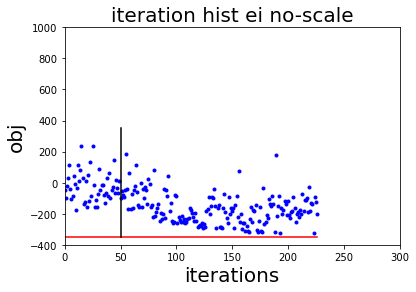

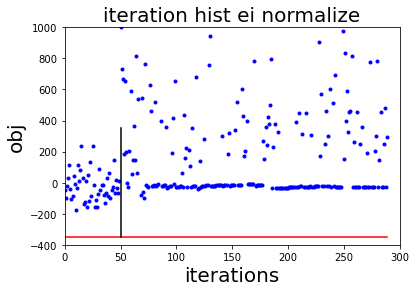

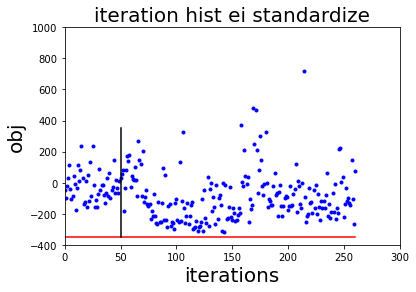

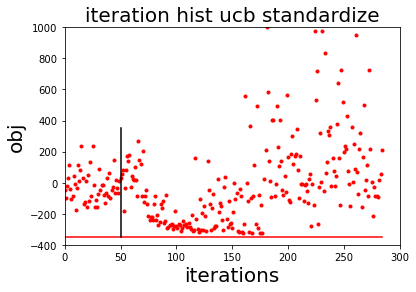

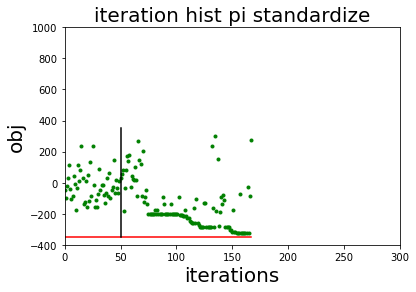

In [9]:
import matplotlib.pyplot as plt # import plotting tools to create figures
global_min=-39.166 * N_Design_param

opt_hist = pd.read_csv('bo_history_9d_ei_noscale.csv', index_col=False)   # reading the csv file above. this is saved version
opt_hist.iloc[0:,:]                                                         # reformating
opt_hist.index
fig_data, ax_data = plt.subplots()                    # create a plot
ax_data.plot(opt_hist.index, opt_hist.obj, 'b.')    # dot plot
ax_data.plot([0, np.max(opt_hist.index)], [global_min, global_min], 'r-')    # global opt
ax_data.plot([N_Init, N_Init], [global_min, -global_min], 'k-')    # initial guess
ax_data.set_xlabel("iterations", fontsize=20)         # create x-axis label with font size 20
ax_data.set_ylabel("obj", fontsize=20)                # create y-axis label with font size 20
ax_data.set_title("iteration hist ei no-scale", fontsize=20);     # create title with font size 20
ax_data.set_xlim([0, 300])
ax_data.set_ylim([-400, 1000])

opt_hist = pd.read_csv('bo_history_9d_ei_normalize.csv', index_col=False)   # reading the csv file above. this is saved version
opt_hist.iloc[0:,:]                                                         # reformating
opt_hist.index
fig_data, ax_data = plt.subplots()                    # create a plot
ax_data.plot(opt_hist.index, opt_hist.obj, 'b.')    # dot plot
ax_data.plot([0, np.max(opt_hist.index)], [global_min, global_min], 'r-')    # global opt
ax_data.plot([N_Init, N_Init], [global_min, -global_min], 'k-')    # initial guess
ax_data.set_xlabel("iterations", fontsize=20)         # create x-axis label with font size 20
ax_data.set_ylabel("obj", fontsize=20)                # create y-axis label with font size 20
ax_data.set_title("iteration hist ei normalize", fontsize=20);     # create title with font size 20
ax_data.set_xlim([0, 300])
ax_data.set_ylim([-400, 1000])

opt_hist = pd.read_csv('bo_history_9d_ei_standardize.csv', index_col=False)   # reading the csv file above. this is saved version
opt_hist.iloc[0:,:]                                                         # reformating
opt_hist.index
fig_data, ax_data = plt.subplots()                    # create a plot
ax_data.plot(opt_hist.index, opt_hist.obj, 'b.')    # dot plot
ax_data.plot([0, np.max(opt_hist.index)], [global_min, global_min], 'r-')    # global opt
ax_data.plot([N_Init, N_Init], [global_min, -global_min], 'k-')    # initial guess
ax_data.set_xlabel("iterations", fontsize=20)         # create x-axis label with font size 20
ax_data.set_ylabel("obj", fontsize=20)                # create y-axis label with font size 20
ax_data.set_title("iteration hist ei standardize", fontsize=20);     # create title with font size 20
ax_data.set_xlim([0, 300])
ax_data.set_ylim([-400, 1000])

opt_hist = pd.read_csv('bo_history_9d_lcb_standardize.csv', index_col=False)   # reading the csv file above. this is saved version
opt_hist.iloc[0:,:]                                                         # reformating
opt_hist.index
fig_data, ax_data = plt.subplots()                    # create a plot
ax_data.plot(opt_hist.index, opt_hist.obj, 'r.')    # dot plot
ax_data.plot([0, np.max(opt_hist.index)], [global_min, global_min], 'r-')    # global opt
ax_data.plot([N_Init, N_Init], [global_min, -global_min], 'k-')    # initial guess
ax_data.set_xlabel("iterations", fontsize=20)         # create x-axis label with font size 20
ax_data.set_ylabel("obj", fontsize=20)                # create y-axis label with font size 20
ax_data.set_title("iteration hist ucb standardize", fontsize=20);     # create title with font size 20
ax_data.set_xlim([0, 300])
ax_data.set_ylim([-400, 1000])

opt_hist = pd.read_csv('bo_history_9d_pi_standardize.csv', index_col=False)   # reading the csv file above. this is saved version
opt_hist.iloc[0:,:]                                                         # reformating
opt_hist.index
fig_data, ax_data = plt.subplots()                    # create a plot
ax_data.plot(opt_hist.index, opt_hist.obj, 'g.')    # dot plot
ax_data.plot([0, np.max(opt_hist.index)], [global_min, global_min], 'r-')    # global opt
ax_data.plot([N_Init, N_Init], [global_min, -global_min], 'k-')    # initial guess
ax_data.set_xlabel("iterations", fontsize=20)         # create x-axis label with font size 20
ax_data.set_ylabel("obj", fontsize=20)                # create y-axis label with font size 20
ax_data.set_title("iteration hist pi standardize", fontsize=20);     # create title with font size 20
ax_data.set_xlim([0, 300])
ax_data.set_ylim([-400, 1000])


## Update required to run with Comsol

To run the code above with comsol, we only need to replace the Comsol_Sim(x) we defined above

Unfortunately, comsol does not support the direct connection with python, so we need to define a function which can run comsol with the command line. (after 2020, it seems like some library might be able to run comsol directly from python)

> cmdl = "cd {}/ && comsol mphserver matlab COMSOL_WITH_MATLAB_FILE -nodesktop -mlnosplash".format(folder_path)

by running the command above, we can run the Matlab file in the comsol server. 

<-nodesktop -mlnosplash".format(folder_path)> is to open the matlab in a simple format, at the current folder_path

One major disadvantage of this approach is that we cannot sent the x variables directly into the matlab file.

So here we use a trick.

We wil make a text file, and save the input variables there, and read those text in the matlab.

For example, 

> a_Design_var1_txt_file  = "{}/a1_Design_var1.txt".format(folder_path)

> open(a_Design_var1_txt_file, "w").write(str(x[0]))

This part will be included in the function.

Here, we have to option in the practical use.

We should be carefull that the matlab is being opened in the right folder so that the matlab can read the m file.

This is something which should be checked with the matlab option before running the code.

So, finally we only need to update the comsol_sim(x) as below for the use of Comsol simultion when we have the matlab model.

Of course, note that the part above defining the objective function should be updated.

Note that, to run the comsol simulation we need to have the comsol license and the comsol/comsol with matlab should have been installed.

One can install from here

https://software.tudelft.nl/

For the next, we need to handle with the matlab file to understand the functional call for the resonator's Q



One final remark is that for the spiderweb nanomechanical resonator paper, I have used the GPyOpt library rather than the Emukit.

However, for the use in the future, the GPyOpt has stopped the update so would be better to move for emukit or botorch library.

Also, one part I skipped here was about the linear constraint of the domain.

when we defined the parameterspace above, we can add the linear constraint for the optimization

ex. for the spiderweb resonator the inner ring cannot surpass the outer beam (L1<L2)

That information can be found in the function below.

miniconda3/envs/emukit_tutorial/lib/python3.7/site-packages/emukit/core/parameter_space.py

This is something which can be differ when we select the different library, but almost the same.




## Submitting in the server

Unlike running the optimization with the personal desktop, we need an small update when running with the TUD cluster.

When we submit the optimization code in the cluster, we cannot run the python directly.

We need to submit the shell script commaning to run our python file.

During that, we need to set the number of nodes(-nn1 -np4) and specify the comsol lisence(-port #) for the automatic optimization.

Below you can see come related documents.

In a quick summary using the tudelft hpc, you can consider nn means number of nodes, and np means number of cores.

http://www.hpc.lsu.edu/docs/guides/software.php?software=comsol

making it short, you can change the command line below.

Note that each lisence number should be different with other optimization submitted.

I usually used 2021-2040.

Finally, do not forget to change the line in the comsol sim above

>    os.system(cmdl_hpc)       # Running the command line above for hpc



## End of the python part!